## Build a contact network

# Download dataset

In [34]:
#!wget https://lp-prod-resources.s3.amazonaws.com/628/66549/2021-06-25-19-30-14/PeopleLocations.csv

In [35]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn import preprocessing

In [36]:
# read in csv to pd.DataFrame
df = pd.read_csv("PeopleLocations.csv", sep = ";", 
                 parse_dates=['Date'], dtype={'id': np.str_, 'Lat': np.float32, 'Lon': np.float32})

In [37]:
# convert type to category
df["Covid19"] = df["Covid19"].astype("category")

In [38]:
# check the dtypes
df.dtypes

ID                 object
Lat               float32
Lon               float32
Date       datetime64[ns]
Time               object
Covid19          category
dtype: object

In [39]:
# rename the first column 
df.rename(columns={"ID": "IDcol"}, inplace=True)

In [40]:
# a bit of the data
df.head(10)

,IDcol,Lat,Lon,Date,Time,Covid19
0,Person1,60.185390,25.009689,2021-09-06,13:52:09,n
1,Person2,60.185387,25.009678,2021-09-06,13:52:09,n
2,Person3,60.185390,25.009695,2021-09-06,13:52:09,n
3,Person4,60.185390,25.009689,2021-09-06,13:52:09,y
4,Person5,60.185387,25.009672,2021-09-06,13:52:09,n
5,Person6,60.185394,25.009706,2021-09-06,13:52:09,n
6,Person7,60.185383,25.009668,2021-09-06,13:52:09,y
7,Person8,60.185387,25.009686,2021-09-06,13:52:09,n
8,Person9,60.185379,25.009634,2021-09-06,13:52:09,n
9,Person10,60.185387,25.009678,2021-09-06,13:52:09,n


In [41]:
# determine a list of different individuals for which there is at least one record in the csv file 
dups = df[df.IDcol.duplicated()]

# count the number of different individuals. this will be the number of nodes in the contace network 
no_of_nodes = df.shape[0]


f"They are no duplicates in the dataset. However, {no_of_nodes} is the number of nodes."

'They are no duplicates in the dataset. However, 300 is the number of nodes.'

In [42]:
df[["Covid19"]]

,Covid19
0,n
1,n
2,n
3,y
4,n
...,...
295,n
296,y
297,y
298,y


In [43]:
# preprocessing the dataframe: Covid19 column 
# 0 = no covid19, 1 = covid19 using sklearn.preprocessing.LabelEncoder 
# use apply() to apply the LabelEncoder to the Covid19 column
le = preprocessing.LabelEncoder()
df["Covid19"] = df[["Covid19"]].apply(le.fit_transform)

In [44]:
no_of_nodes = df.shape[0]

In [45]:
# create a graph object
G = nx.Graph()

# add a node with index `nodeidx` to the graph object `G`
for nodeidx in range(no_of_nodes):
    G.add_node(nodeidx)
    G.nodes[nodeidx]["name"] = df.loc[nodeidx, "IDcol"]
    G.nodes[nodeidx]["coords"] = np.array([df.loc[nodeidx, "Lat"], df.loc[nodeidx, "Lon"]])
    G.nodes[nodeidx]["timestamp"] = df.loc[nodeidx, "Date"]
    G.nodes[nodeidx]["Rate"] = df.loc[nodeidx, "Covid19"]
    

In [46]:
# see graph nodes
# to see data add data=true
G.nodes(data=True)

NodeDataView({0: {'name': 'Person1', 'coords': array([60.18539, 25.00969], dtype=float32), 'timestamp': Timestamp('2021-09-06 00:00:00'), 'Rate': 0}, 1: {'name': 'Person2', 'coords': array([60.185387, 25.009678], dtype=float32), 'timestamp': Timestamp('2021-09-06 00:00:00'), 'Rate': 0}, 2: {'name': 'Person3', 'coords': array([60.18539 , 25.009695], dtype=float32), 'timestamp': Timestamp('2021-09-06 00:00:00'), 'Rate': 0}, 3: {'name': 'Person4', 'coords': array([60.18539, 25.00969], dtype=float32), 'timestamp': Timestamp('2021-09-06 00:00:00'), 'Rate': 1}, 4: {'name': 'Person5', 'coords': array([60.185387, 25.009672], dtype=float32), 'timestamp': Timestamp('2021-09-06 00:00:00'), 'Rate': 0}, 5: {'name': 'Person6', 'coords': array([60.185394, 25.009706], dtype=float32), 'timestamp': Timestamp('2021-09-06 00:00:00'), 'Rate': 0}, 6: {'name': 'Person7', 'coords': array([60.185383, 25.009668], dtype=float32), 'timestamp': Timestamp('2021-09-06 00:00:00'), 'Rate': 1}, 7: {'name': 'Person8', '

In [47]:
def geodesic_distance(nodeidx1, nodeidx2):
    '''
    distance between two individuals in meters

    Parameters
    ----------
    nodeidx1 : int
        index of first individual

    nodeidx2 : int
        index of second individual
    
    Returns
    -------
    dist : float
        distance between two individuals in meters

    Example
    -------
    >>> geodesic_distance(0, 1)
    0.0
    '''
    # get the coordinates of the two individuals
    coords1 = G.nodes[nodeidx1]["coords"]
    coords2 = G.nodes[nodeidx2]["coords"]
    # compute the distance between the two individuals
    dist = np.linalg.norm(coords1 - coords2)
    # return the distance in meters
    return dist

# if distance is below two meters connect individuals by and edge
for nodeidx1 in range(no_of_nodes):
    for nodeidx2 in range(no_of_nodes):
        if nodeidx1 != nodeidx2:
            dist = geodesic_distance(nodeidx1, nodeidx2)
            if dist < 2:
                G.add_edge(nodeidx1, nodeidx2)

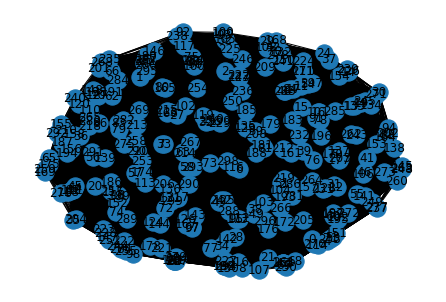

In [48]:
# visualize the graph
nx.draw(G, with_labels=True)

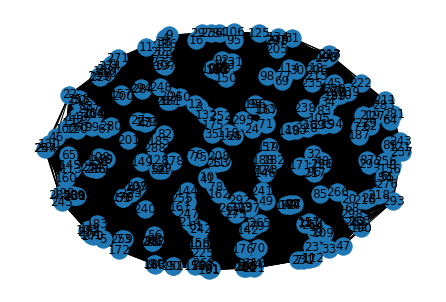

In [49]:
# change layout to spread out the nodes
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)